In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr, spearmanr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from apa_variant_prediction_utils import *


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 65
proximal_end = 90

file_prefix = str(proximal_start) + "_" + str(proximal_end)


In [3]:
#Load variant dataframe
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions (Resnet)
model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

pred_dict['cut_prob'] = pred_dict['cut_prob'][:, 20:]

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'], proximal_start=proximal_start, proximal_end=proximal_end, isoform_pseudo_count=isoform_pseudo_count)


n (variants) = 21734


In [4]:
#Filter on high quality

print("n (pre-filtering) = " + str(len(variant_df)))

variant_df = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

print("n (post-filtering) = " + str(len(variant_df)))


n (pre-filtering) = 21734
n (post-filtering) = 19734


In [5]:
#Mark wildtype TGTA-containing sequences

variant_df['tgta_fixed'] = variant_df['wt_seq'].str.contains("TGTA")

#Set prediction columns
variant_df['delta_logodds_pred'] = variant_df['delta_logodds_pred_from_cuts']


In [6]:
#Extract TGTA insertion simulation data

tgta_1_df = variant_df.query("experiment == 'tgta' and subexperiment == 'n=1' and tgta_fixed == False").copy().reset_index(drop=True)
tgta_2_df = variant_df.query("experiment == 'tgta' and subexperiment == 'n=2' and tgta_fixed == False").copy().reset_index(drop=True)


In [7]:
#Re-map TGTA insertion positions

def _get_tgta_pos_1(row) :
    pos = -1
    for j in range(len(row['wt_seq']) - 4 + 1) :
        if row['wt_seq'][j:j+4] != "TGTA" and row['master_seq'][j:j+4] == "TGTA" :
            pos = j
            break
    
    return pos

def _get_tgta_pos_2(row) :
    pos = -1
    for j in range(len(row['wt_seq']) - 4, -1, -1) :
        if row['wt_seq'][j:j+4] != "TGTA" and row['master_seq'][j:j+4] == "TGTA" :
            pos = j
            break
    
    return pos

tgta_1_df['tgta_pos'] = tgta_1_df.apply(_get_tgta_pos_1, axis=1).astype(int)

tgta_2_df['tgta_pos_1'] = tgta_2_df.apply(_get_tgta_pos_1, axis=1).astype(int)
tgta_2_df['tgta_pos_2'] = tgta_2_df.apply(_get_tgta_pos_2, axis=1).astype(int)


In [8]:
#Map single-TGTA data to double-TGTA data

def _get_tgta_1_mut_seq(row) :
    return row['wt_seq'][:int(row['tgta_pos_1'])] + "TGTA" + row['wt_seq'][int(row['tgta_pos_1'])+4:]

def _get_tgta_2_mut_seq(row) :
    return row['wt_seq'][:int(row['tgta_pos_2'])] + "TGTA" + row['wt_seq'][int(row['tgta_pos_2'])+4:]

tgta_2_df['wt_seq_tgta_1'] = tgta_2_df.apply(_get_tgta_1_mut_seq, axis=1)
tgta_2_df['wt_seq_tgta_2'] = tgta_2_df.apply(_get_tgta_2_mut_seq, axis=1)

tgta_2_df = tgta_2_df.join(tgta_1_df[['master_seq', 'delta_logodds_pred', 'delta_logodds_true']].set_index("master_seq"), on='wt_seq_tgta_1', how='inner', rsuffix='_1').copy().reset_index(drop=True)
tgta_2_df = tgta_2_df.join(tgta_1_df[['master_seq', 'delta_logodds_pred', 'delta_logodds_true']].set_index("master_seq"), on='wt_seq_tgta_2', how='inner', rsuffix='_2').copy().reset_index(drop=True)

#Calculate epistatic interaction effect sizes
tgta_2_df['epi_logodds_true'] = tgta_2_df['delta_logodds_true'] - (tgta_2_df['delta_logodds_true_1'] + tgta_2_df['delta_logodds_true_2'])
tgta_2_df['epi_logodds_pred'] = tgta_2_df['delta_logodds_pred'] - (tgta_2_df['delta_logodds_pred_1'] + tgta_2_df['delta_logodds_pred_2'])


wt_ix = 0 (ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCGTCATAATAAAGAGGAATGGTGTGTTGGTCTGTGTCTCGTTCATTGCTGGTCGAGCTTACATTCCACGTTCGTCTGCTTCCGATACCCCGTATATAGGTCTTTGGAAGACGTATCCCCG)


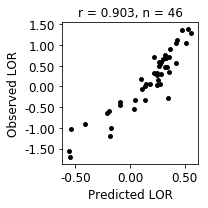

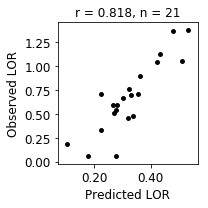

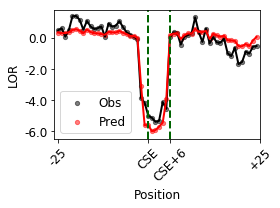

wt_ix = 1 (ACTTCGCTTCCTGCGTTTATCTAGCCAAACATGGTAAGACTACGACTTCAAATAAATCGACTTCCCGCCAGACGGTGTGTCTCGTCGAGCCCGTAGAACTGATCGGCACAGTATTAGTCAGAGCCTTCTACAGCCGTCGTTAGACTTATATGAGTGGCTGGCTT)


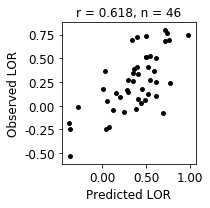

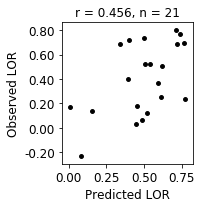

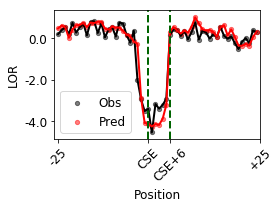

wt_ix = 2 (GTCCCATCCACTAGTTCCCATTCTTGCATAGGTCTCCGGAGTGCGCCTCCAATAAAGGTAGTCACGTTTCCGTGCTGTGTCTCGTGGCGGAACGCGGCCGCGCTGTCAGTATGTCTTAGCCGAAATTGCCGCGACGACAACTTCACGCTGAATAGTAGTGGGCA)


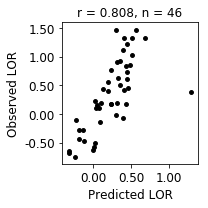

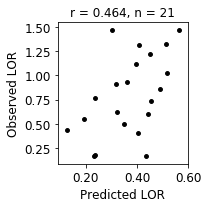

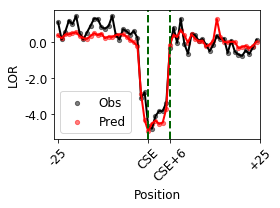

-- mean ---


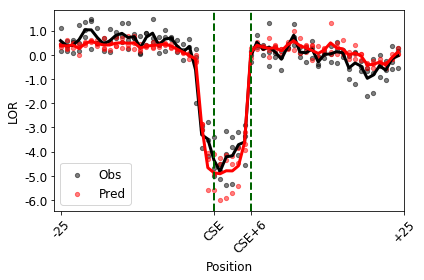

In [9]:
#Single TGTA Analysis

wt_seqs = np.unique(tgta_1_df['wt_seq']).tolist()

for wt_ix, wt_seq in enumerate(wt_seqs) :
    
    print("wt_ix = " + str(wt_ix) + " (" + str(wt_seq) + ")")
    
    sel_df = tgta_1_df.query("wt_seq == '" + str(wt_seq) + "'").sort_values(by='tgta_pos').copy().reset_index(drop=True)
    
    r_val = np.round(spearmanr(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_pred'], sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'])[0], 3)
    
    f = plt.figure(figsize=(3, 3))
    
    plt.scatter(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_pred'], sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'], s=15, color='black')

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("Predicted LOR", fontsize=12)
    plt.ylabel("Observed LOR", fontsize=12)
    
    plt.title("r = " + str(r_val) + ", n = " + str(len(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56"))))
    
    plt.tight_layout()
    
    plt.savefig("tgta_1_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_1_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")
    
    plt.show()
    
    r_val = np.round(spearmanr(sel_df.query("tgta_pos < 50-4")['delta_logodds_pred'], sel_df.query("tgta_pos < 50-4")['delta_logodds_true'])[0], 3)
    
    f = plt.figure(figsize=(3, 3))
    
    plt.scatter(sel_df.query("tgta_pos < 50-4")['delta_logodds_pred'], sel_df.query("tgta_pos < 50-4")['delta_logodds_true'], s=15, color='black')

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("Predicted LOR", fontsize=12)
    plt.ylabel("Observed LOR", fontsize=12)
    
    plt.title("r = " + str(r_val) + ", n = " + str(len(sel_df.query("tgta_pos < 50-4"))))
    
    plt.tight_layout()
    
    plt.savefig("tgta_1_scatter_use_only_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_1_scatter_use_only_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")
    
    plt.show()
    
    f = plt.figure(figsize=(4, 3))

    plt.scatter(sel_df['tgta_pos'], sel_df['delta_logodds_true'], color='black', alpha=0.5, s=18, label='Obs')
    plt.scatter(sel_df['tgta_pos'], sel_df['delta_logodds_pred'], color='red', alpha=0.5, s=18, label='Pred')
    
    plt.plot(sel_df['tgta_pos'], sel_df['delta_logodds_true'], linewidth=2, color='black', linestyle='-', label="")
    plt.plot(sel_df['tgta_pos'], sel_df['delta_logodds_pred'], linewidth=2, color='red', linestyle='-', label="")
    
    plt.axvline(x=50, linewidth=2, linestyle='--', color='darkgreen')
    plt.axvline(x=56, linewidth=2, linestyle='--', color='darkgreen')
    
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.xticks([25, 50, 56, 81], ["-25", "CSE", "CSE+6", "+25"], rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("Position", fontsize=12)
    plt.ylabel("LOR", fontsize=12)
    
    plt.xlim(24, 81)
    
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    
    plt.savefig("tgta_1_pos_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_1_pos_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")

    plt.show()


tgta_1_df_sorted = tgta_1_df.sort_values(by='tgta_pos').copy().reset_index(drop=True)
tgta_1_df_agg = tgta_1_df_sorted.groupby(['tgta_pos']).agg({'delta_logodds_pred' : 'mean', 'delta_logodds_true' : 'mean'}).reset_index()

print("-- mean ---")

f = plt.figure(figsize=(6, 4))

plt.scatter(tgta_1_df_sorted['tgta_pos'], tgta_1_df_sorted['delta_logodds_true'], color='black', alpha=0.5, s=18, label='Obs')
plt.scatter(tgta_1_df_sorted['tgta_pos'], tgta_1_df_sorted['delta_logodds_pred'], color='red', alpha=0.5, s=18, label='Pred')

plt.plot(tgta_1_df_agg['tgta_pos'], tgta_1_df_agg['delta_logodds_true'], linewidth=3, color='black', linestyle='-', label="")
plt.plot(tgta_1_df_agg['tgta_pos'], tgta_1_df_agg['delta_logodds_pred'], linewidth=3, color='red', linestyle='-', label="")

plt.axvline(x=50, linewidth=2, linestyle='--', color='darkgreen')
plt.axvline(x=56, linewidth=2, linestyle='--', color='darkgreen')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xticks([25, 50, 56, 81], ["-25", "CSE", "CSE+6", "+25"], rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.ylabel("LOR", fontsize=12)

plt.xlim(24, 81)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("tgta_1_pos_mean_aparent_resnet_master_seq.png", transparent=True, dpi=300)
plt.savefig("tgta_1_pos_mean_aparent_resnet_master_seq.eps")

plt.show()


-- mean ---


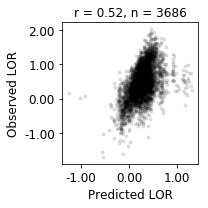

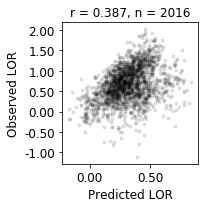

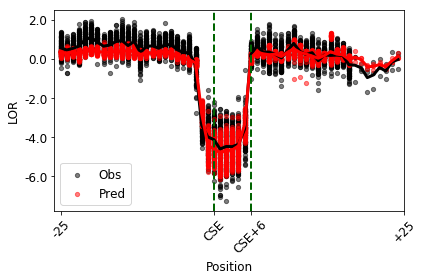

In [10]:
#Combined mean position plot (include double-TGTA data)

tgta_combined_df = tgta_1_df.copy().reset_index(drop=True)

tgta_2_df_copy_1 = tgta_2_df.copy().reset_index(drop=True)
tgta_2_df_copy_1 = tgta_2_df_copy_1.query("(tgta_pos_1 < 50-4 or tgta_pos_1 >= 56)").copy().reset_index(drop=True)

tgta_2_df_copy_1['tgta_pos'] = tgta_2_df_copy_1['tgta_pos_2']
tgta_2_df_copy_1['delta_logodds_true'] = tgta_2_df_copy_1['delta_logodds_true'] - tgta_2_df_copy_1['delta_logodds_true_1']
tgta_2_df_copy_1['delta_logodds_pred'] = tgta_2_df_copy_1['delta_logodds_pred'] - tgta_2_df_copy_1['delta_logodds_pred_1']

tgta_2_df_copy_2 = tgta_2_df.copy().reset_index(drop=True)
tgta_2_df_copy_2 = tgta_2_df_copy_2.query("(tgta_pos_2 < 50-4 or tgta_pos_2 >= 56)").copy().reset_index(drop=True)

tgta_2_df_copy_2['tgta_pos'] = tgta_2_df_copy_2['tgta_pos_1']
tgta_2_df_copy_2['delta_logodds_true'] = tgta_2_df_copy_2['delta_logodds_true'] - tgta_2_df_copy_2['delta_logodds_true_2']
tgta_2_df_copy_2['delta_logodds_pred'] = tgta_2_df_copy_2['delta_logodds_pred'] - tgta_2_df_copy_2['delta_logodds_pred_2']

tgta_combined_df = pd.concat([
    tgta_combined_df,
    tgta_2_df_copy_1,
    tgta_2_df_copy_2,
]).copy().reset_index(drop=True)


tgta_1_df_sorted = tgta_combined_df.sort_values(by='tgta_pos').copy().reset_index(drop=True)
tgta_1_df_agg = tgta_1_df_sorted.groupby(['tgta_pos']).agg({'delta_logodds_pred' : 'mean', 'delta_logodds_true' : 'mean'}).reset_index()

print("-- mean ---")


r_val = np.round(spearmanr(tgta_1_df_sorted.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_pred'], tgta_1_df_sorted.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'])[0], 3)
    
f = plt.figure(figsize=(3, 3))

plt.scatter(tgta_1_df_sorted.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_pred'], tgta_1_df_sorted.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'], s=8, alpha=0.1, color='black')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Observed LOR", fontsize=12)

plt.title("r = " + str(r_val) + ", n = " + str(len(tgta_1_df_sorted.query("tgta_pos < 50-4 or tgta_pos >= 56"))))

plt.tight_layout()

plt.savefig("tgta_combined_scatter_mean_aparent_resnet_master_seq.png", transparent=True, dpi=300)
plt.savefig("tgta_combined_scatter_mean_aparent_resnet_master_seq.eps")

plt.show()


r_val = np.round(spearmanr(tgta_1_df_sorted.query("tgta_pos < 50-4")['delta_logodds_pred'], tgta_1_df_sorted.query("tgta_pos < 50-4")['delta_logodds_true'])[0], 3)
    
f = plt.figure(figsize=(3, 3))

plt.scatter(tgta_1_df_sorted.query("tgta_pos < 50-4")['delta_logodds_pred'], tgta_1_df_sorted.query("tgta_pos < 50-4")['delta_logodds_true'], s=8, alpha=0.1, color='black')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Observed LOR", fontsize=12)

plt.title("r = " + str(r_val) + ", n = " + str(len(tgta_1_df_sorted.query("tgta_pos < 50-4"))))

plt.tight_layout()

plt.savefig("tgta_combined_scatter_use_only_mean_aparent_resnet_master_seq.png", transparent=True, dpi=300)
plt.savefig("tgta_combined_scatter_use_only_mean_aparent_resnet_master_seq.eps")

plt.show()


f = plt.figure(figsize=(6, 4))

plt.scatter(tgta_1_df_sorted['tgta_pos'], tgta_1_df_sorted['delta_logodds_true'], color='black', alpha=0.5, s=18, label='Obs')
plt.scatter(tgta_1_df_sorted['tgta_pos'], tgta_1_df_sorted['delta_logodds_pred'], color='red', alpha=0.5, s=18, label='Pred')

plt.plot(tgta_1_df_agg['tgta_pos'], tgta_1_df_agg['delta_logodds_true'], linewidth=3, color='black', linestyle='-', label="")
plt.plot(tgta_1_df_agg['tgta_pos'], tgta_1_df_agg['delta_logodds_pred'], linewidth=3, color='red', linestyle='-', label="")

plt.axvline(x=50, linewidth=2, linestyle='--', color='darkgreen')
plt.axvline(x=56, linewidth=2, linestyle='--', color='darkgreen')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xticks([25, 50, 56, 81], ["-25", "CSE", "CSE+6", "+25"], rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.ylabel("LOR", fontsize=12)

plt.xlim(24, 81)

plt.legend(fontsize=12)

plt.tight_layout()
    
plt.savefig("tgta_combined_pos_mean_aparent_resnet_master_seq.png", transparent=True, dpi=300)
plt.savefig("tgta_combined_pos_mean_aparent_resnet_master_seq.eps")

plt.show()


wt_ix = 0 (ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCGTCATAATAAAGAGGAATGGTGTGTTGGTCTGTGTCTCGTTCATTGCTGGTCGAGCTTACATTCCACGTTCGTCTGCTTCCGATACCCCGTATATAGGTCTTTGGAAGACGTATCCCCG)
(0.8158442045494262, 1.3126121052485127e-144)
SpearmanrResult(correlation=0.7627100563666047, pvalue=1.8092658352884248e-115)


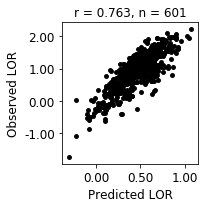

(0.7651720417255792, 1.1220645568770308e-30)
SpearmanrResult(correlation=0.7527709648452682, pvalue=3.259761131337028e-29)


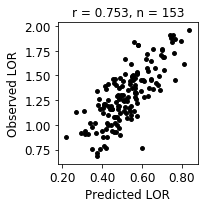

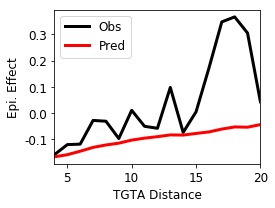

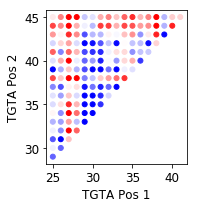

wt_ix_1 = 0 vs wt_ix_2 = 0
 --- r = 1.0, n = 153
wt_ix_1 = 0 vs wt_ix_2 = 1
 --- r = -0.1, n = 153
wt_ix_1 = 0 vs wt_ix_2 = 2
 --- r = -0.1, n = 142
wt_ix = 1 (ACTTCGCTTCCTGCGTTTATCTAGCCAAACATGGTAAGACTACGACTTCAAATAAATCGACTTCCCGCCAGACGGTGTGTCTCGTCGAGCCCGTAGAACTGATCGGCACAGTATTAGTCAGAGCCTTCTACAGCCGTCGTTAGACTTATATGAGTGGCTGGCTT)
(0.6045933655171727, 8.880613440082713e-61)
SpearmanrResult(correlation=0.612570927020838, pvalue=8.916043418333313e-63)


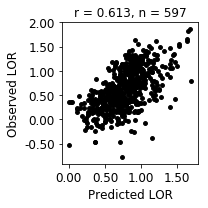

(0.5977706340445815, 3.414621623761819e-16)
SpearmanrResult(correlation=0.6151843512524626, pvalue=2.663985307133535e-17)


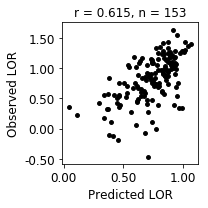

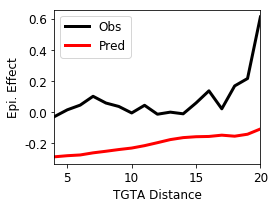

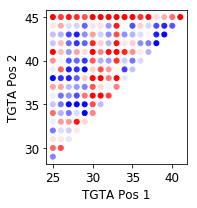

wt_ix_1 = 1 vs wt_ix_2 = 0
 --- r = -0.1, n = 153
wt_ix_1 = 1 vs wt_ix_2 = 1
 --- r = 1.0, n = 153
wt_ix_1 = 1 vs wt_ix_2 = 2
 --- r = -0.015, n = 142
wt_ix = 2 (GTCCCATCCACTAGTTCCCATTCTTGCATAGGTCTCCGGAGTGCGCCTCCAATAAAGGTAGTCACGTTTCCGTGCTGTGTCTCGTGGCGGAACGCGGCCGCGCTGTCAGTATGTCTTAGCCGAAATTGCCGCGACGACAACTTCACGCTGAATAGTAGTGGGCA)
(0.6514537527994497, 7.307925225219167e-71)
SpearmanrResult(correlation=0.7612794187828097, pvalue=4.4392233044768727e-110)


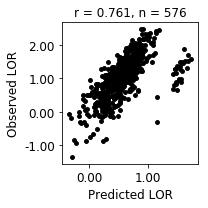

(0.7435756901971511, 3.036239077948462e-26)
SpearmanrResult(correlation=0.7507999941323287, pvalue=5.43451673011412e-27)


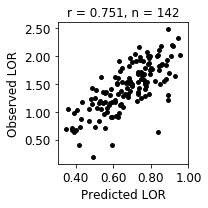

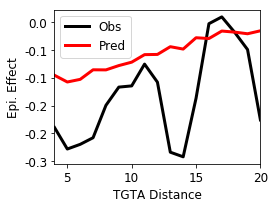

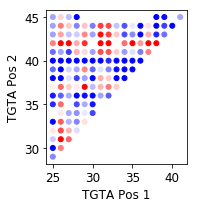

wt_ix_1 = 2 vs wt_ix_2 = 0
 --- r = -0.1, n = 142
wt_ix_1 = 2 vs wt_ix_2 = 1
 --- r = -0.015, n = 142
wt_ix_1 = 2 vs wt_ix_2 = 2
 --- r = 1.0, n = 142


In [11]:
#Double TGTA Analysis

wt_seqs = np.unique(tgta_2_df['wt_seq']).tolist()

for wt_ix, wt_seq in enumerate(wt_seqs) :
    
    print("wt_ix = " + str(wt_ix) + " (" + str(wt_seq) + ")")
    
    sel_df = tgta_2_df.query("wt_seq == '" + str(wt_seq) + "' and (tgta_pos_1 < 50-4 or tgta_pos_1 >= 56) and (tgta_pos_2 < 50-4 or tgta_pos_2 >= 56) and (tgta_pos_2 - tgta_pos_1 >= 4)").copy()#.sort_values(by='tgta_pos').copy().reset_index(drop=True)
    
    print(pearsonr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true']))
    print(spearmanr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true']))

    r_val = np.round(spearmanr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true'])[0], 3)

    f = plt.figure(figsize=(3, 3))

    plt.scatter(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true'], s=15, color='black')

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Predicted LOR", fontsize=12)
    plt.ylabel("Observed LOR", fontsize=12)

    plt.title("r = " + str(r_val) + ", n = " + str(len(sel_df)))

    plt.tight_layout()

    plt.savefig("tgta_2_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_2_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")

    plt.show()
    
    sel_df = sel_df.query("tgta_pos_1 <= 50 and tgta_pos_2 <= 50")
    
    print(pearsonr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true']))
    print(spearmanr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true']))

    r_val = np.round(spearmanr(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true'])[0], 3)

    f = plt.figure(figsize=(3, 3))

    plt.scatter(sel_df['delta_logodds_pred'], sel_df['delta_logodds_true'], s=15, color='black')

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Predicted LOR", fontsize=12)
    plt.ylabel("Observed LOR", fontsize=12)

    plt.title("r = " + str(r_val) + ", n = " + str(len(sel_df)))

    plt.tight_layout()

    plt.savefig("tgta_2_scatter_use_only_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_2_scatter_use_only_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")

    plt.show()
    
    sel_df['tgta_dist'] = sel_df['tgta_pos_2'] - sel_df['tgta_pos_1']
    agg_df = sel_df.groupby(['tgta_dist']).agg({'epi_logodds_pred' : 'mean', 'epi_logodds_true' : 'mean'}).reset_index().sort_values(by='tgta_dist').copy().reset_index(drop=True)

    f = plt.figure(figsize=(4, 3))

    plt.plot(agg_df['tgta_dist'], agg_df['epi_logodds_true'], linewidth=3, color='black', linestyle='-', label='Obs')
    plt.plot(agg_df['tgta_dist'], agg_df['epi_logodds_pred'], linewidth=3, color='red', linestyle='-', label='Pred')

    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("TGTA Distance", fontsize=12)
    plt.ylabel("Epi. Effect", fontsize=12)

    plt.xlim(4, 20)

    plt.legend(fontsize=12)

    plt.tight_layout()

    plt.savefig("tgta_2_dist_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_2_dist_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")

    plt.show()
    
    
    f = plt.figure(figsize=(3, 3))

    plt.scatter(sel_df['tgta_pos_1'], sel_df['tgta_pos_2'], c=sel_df['epi_logodds_true'], cmap='bwr', vmin=-0.5, vmax=0.5, s=25)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("TGTA Pos 1", fontsize=12)
    plt.ylabel("TGTA Pos 2", fontsize=12)

    plt.tight_layout()

    plt.savefig("tgta_2_pos_vs_pos_true_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_2_pos_vs_pos_true_wt_ix_" + str(wt_ix) + "_aparent_resnet_master_seq.eps")

    plt.show()
    
    sel_df['tgta_key'] = sel_df['tgta_pos_1'].astype(str) + "_" + sel_df['tgta_pos_2'].astype(str)
    
    for wt_ix_2, wt_seq_2 in enumerate(wt_seqs) :
    
        print("wt_ix_1 = " + str(wt_ix) + " vs wt_ix_2 = " + str(wt_ix_2))

        sel_df_2 = tgta_2_df.query("wt_seq == '" + str(wt_seq_2) + "' and (tgta_pos_1 < 50-4 or tgta_pos_1 >= 56) and (tgta_pos_2 < 50-4 or tgta_pos_2 >= 56) and (tgta_pos_2 - tgta_pos_1 >= 4)").copy()#.sort_values(by='tgta_pos').copy().reset_index(drop=True)
        
        sel_df_2['tgta_key'] = sel_df_2['tgta_pos_1'].astype(str) + "_" + sel_df_2['tgta_pos_2'].astype(str)
        
        join_df = sel_df.join(sel_df_2[['tgta_key', 'epi_logodds_true']].set_index("tgta_key"), on='tgta_key', how='inner', rsuffix='_2').copy().reset_index(drop=True)
        
        r_val = np.round(spearmanr(join_df['epi_logodds_true'], join_df['epi_logodds_true_2'])[0], 3)
        
        print(" --- r = " + str(r_val) + ", n = " + str(len(join_df)))
